## Reading csv

In [ ]:
import pandas as pd
try:
  df = pd.read_csv('home_energy_data.csv')
  print(df.head()) # Display the first few rows to verify
except FileNotFoundError:
  print("Error: 'home_energy_data.csv' not found. Please ensure the file exists in the current directory or provide the correct path.")
except pd.errors.EmptyDataError:
  print("Error: 'home_energy_data.csv' is empty.")
except pd.errors.ParserError:
  print("Error: Could not parse 'home_energy_data.csv'. Please check the file format.")
except Exception as e:
  print(f"An unexpected error occurred: {e}")


              datetime  Appliances     lights         T1       RH_1  \
0  2020-11-20 06:36:00    9.224074  11.780934  21.353076  28.785449   
1  2020-03-13 20:22:00   39.255901  60.716264  35.487458  41.356428   
2  2022-03-12 01:56:00   35.940710  65.406471  47.017619  63.418386   
3  2021-12-14 07:10:00   41.084820  86.065163  23.978005  23.393887   
4  2021-10-12 03:33:00   16.906166  10.180642  36.304494  66.095897   

          T2       RH_2         T3       RH_3         T4  ...        T9  \
0   6.129020  27.960747  15.348167  28.330292   4.154281  ...  5.923630   
1  15.903235  20.507539  27.672137  22.920486  12.124937  ...  6.061692   
2  13.095685  54.531559  34.191016  61.558161   7.795195  ...  6.447738   
3   9.435890  26.694852  16.212792  17.039071   4.614822  ...  5.286256   
4   2.251706  51.922185  27.846892  66.290309   0.794317  ...  1.668838   

        RH_9      T_out    Pressure     RH_out  Windspeed  Visibility  \
0  28.311018  11.236204  709.237084  39.363552   

## Checking missing values

In [ ]:
print(df.isnull().sum())

datetime      0
Appliances    0
lights        0
T1            0
RH_1          0
T2            0
RH_2          0
T3            0
RH_3          0
T4            0
RH_4          0
T5            0
RH_5          0
T6            0
RH_6          0
T7            0
RH_7          0
T8            0
RH_8          0
T9            0
RH_9          0
T_out         0
Pressure      0
RH_out        0
Windspeed     0
Visibility    0
Tdewpoint     0
rv1           0
rv2           0
dtype: int64


## Detecting outliers

In [ ]:

def detect_outliers_iqr(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

outlier_counts = {}
for column in df.select_dtypes(include=['number']): # Check only numerical columns
    outliers = detect_outliers_iqr(df[column])
    if not outliers.empty:
        outlier_counts[column] = len(outliers)

if outlier_counts:
    print("Outliers detected in the following columns:")
    for column, count in outlier_counts.items():
        print(f"{column}: {count} outliers")
else:
    print("No outliers detected in any numerical column.")

Outliers detected in the following columns:
T4: 1 outliers
T5: 25 outliers
T6: 1 outliers
T9: 3 outliers


## Dropping datetime, rv1 and rv2

In [ ]:
columns_to_drop = ['datetime', 'rv1', 'rv2']
for column in columns_to_drop:
    if column in df.columns:
        df = df.drop(column, axis=1)
    else:
        print(f"Warning: Column '{column}' not found in the DataFrame.")

## Normalizing the data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numerical_cols = df.select_dtypes(include=['number']).columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
print(df.head())

   Appliances    lights        T1      RH_1        T2      RH_2        T3  \
0    0.238863  0.117800  0.385667  0.427057  0.415540  0.477257  0.358687   
1    0.639465  0.607222  0.615161  0.561159  0.920887  0.392103  0.644814   
2    0.595243  0.654131  0.802371  0.796507  0.775731  0.780835  0.796163   
3    0.663861  0.860747  0.428286  0.369542  0.586512  0.462794  0.378761   
4    0.341337  0.101795  0.628426  0.825070  0.215075  0.751022  0.648871   

       RH_3        T4      RH_4  ...        T8      RH_8        T9      RH_9  \
0  0.448773  0.503577  0.268733  ...  0.330525  0.459134  0.554378  0.531894   
1  0.389608  0.925015  0.330983  ...  0.891079  0.544002  0.560436  0.521397   
2  0.812170  0.696085  0.612765  ...  0.676248  0.718789  0.577378  0.663927   
3  0.325286  0.527927  0.338169  ...  0.639376  0.338192  0.526407  0.186627   
4  0.863924  0.325923  0.686715  ...  0.191383  0.659797  0.367659  0.676468   

      T_out  Pressure    RH_out  Windspeed  Visibility  

## Filter method:Pearson correlation (threshold 0.1)

In [ ]:
correlation_with_target = df.corr()['Appliances']
selected_features = correlation_with_target[correlation_with_target > 0.1].index.tolist()
selected_features.remove('Appliances')
print("Features with correlation > 0.1 with 'Appliances':")
print(selected_features)

Features with correlation > 0.1 with 'Appliances':
['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'RH_out']


# Feature selection methods

## Forward Selection

In [ ]:
X = df[selected_features]
y = df['Appliances']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def forward_selection(X_train, X_test, y_train, y_test):
    selected_features_forward = []  # To store selected features
    remaining_features = list(X_train.columns)  # Features to evaluate
    best_r2 = 0  # Best R² value so far

    while remaining_features:
        r2_scores = {}
        for feature in remaining_features:
            # Create a temporary feature set including the current feature
            temp_features = selected_features_forward + [feature]

            # Train a linear regression model
            model = LinearRegression()
            model.fit(X_train[temp_features], y_train)

            # Evaluate on the test set
            y_pred = model.predict(X_test[temp_features])
            r2_scores[feature] = r2_score(y_test, y_pred)

        # Find the feature that gives the highest R²
        best_feature = max(r2_scores, key=r2_scores.get)
        best_feature_r2 = r2_scores[best_feature]

        # If the best R² improves, add the feature
        if best_feature_r2 > best_r2:
            selected_features_forward.append(best_feature)
            remaining_features.remove(best_feature)
            best_r2 = best_feature_r2
        else:
            break  # Stop if no improvement

    return selected_features_forward

# Apply forward selection
final_selected_features_forward = forward_selection(X_train, X_test, y_train, y_test)

# Display the results
print("Final selected features based on forward selection:")
print(final_selected_features_forward)

Final selected features based on forward selection:
['lights', 'T1', 'T_out', 'RH_9', 'T4', 'T9', 'RH_2', 'T2', 'T8']


## Backward Elimination

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Step 5: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Perform backward elimination based on R²
def backward_elimination(X_train, X_test, y_train, y_test):
    selected_features_forward = X_train.columns.tolist()  # Start with all selected features
    best_r2 = -float("inf")  # Start with a very low R² value

    while len(selected_features_forward) > 0:
        r2_scores = {}
        for feature in selected_features_forward:
            # Create a temporary feature set excluding the current feature
            temp_features = [f for f in selected_features_forward if f != feature]

            # Train a linear regression model
            model = LinearRegression()
            model.fit(X_train[temp_features], y_train)

            # Evaluate on the test set
            y_pred = model.predict(X_test[temp_features])
            r2_scores[feature] = r2_score(y_test, y_pred)

        # Find the feature that gives the lowest R² when removed
        feature_to_remove = min(r2_scores, key=r2_scores.get)
        new_r2 = r2_scores[feature_to_remove]

        # If the R² decreases too much, stop the elimination
        if new_r2 >= best_r2:
            best_r2 = new_r2
            selected_features_forward.remove(feature_to_remove)
        else:
            break  # Stop if removing any more features worsens R²

    return selected_features_forward

# Apply backward elimination
final_selected_features_backward = backward_elimination(X_train, X_test, y_train, y_test)

# Display the results
print("Final selected features based on backward elimination:")
print(final_selected_features_backward)

Final selected features based on backward elimination:
['T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'RH_out']


## Particle swarm optimization

In [ ]:
!pip install pyswarms


In [ ]:
!pip install pyswarm


  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=c7f9c4ce3a8d070f8230c0d6b961cca33a1c3a7c7a3f91da68957be0971733f9
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
import pyswarms as ps

# ... (Your existing code for data loading, preprocessing, and outlier detection)

# Step 2: Define fitness function based on R² value
def fitness_function(selected_indices):


    X_selected = X[selected_features]
    X_train_selected, X_test_selected, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.2, random_state=42
    )

    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    r2 = r2_score(y_test, y_pred)

    return 1 - r2  # Minimize 1 - R² to maximize R²

# Step 3: Initialize PSO
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
dimensions = len(selected_features) # Number of features
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=dimensions, options=options)

# Step 4: Run PSO
cost, pos = optimizer.optimize(fitness_function, iters=50)

# Step 5: Select features based on the best position
selected_indices_pso = [i for i, p in enumerate(pos) if p > 0.5]
selected_features_pso = [selected_features[i] for i in selected_indices_pso]
print("Selected features using PSO:")
print(selected_features_pso)

# Step 6: Evaluate the model with selected features from PSO
X_pso = df[selected_features_pso]

X_train_pso, X_test_pso, y_train_pso, y_test_pso = train_test_split(
    X_pso, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train_pso, y_train_pso)

y_pred_pso = model.predict(X_test_pso)
r2_pso = r2_score(y_test_pso, y_pred_pso)
print(f"R² score with PSO-selected features: {r2_pso}")

2024-12-12 14:54:13,195 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.141
2024-12-12 14:54:16,241 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.14072749004847573, best pos: [8.70516474e-04 7.50850853e-01 3.28260838e-01 7.90945105e-02
 8.03371642e-01 9.92683881e-01 2.26995608e-01 5.75870729e-01
 7.31762246e-01 6.02557221e-02 5.13855995e-01 5.47690222e-02
 6.43235887e-01 4.70831233e-02 1.14513095e-01 6.35758652e-01
 5.54985503e-02 2.93757877e-01 3.64726449e-01 1.40875528e-01
 7.64364070e-02]


Selected features using PSO:
['T1', 'RH_2', 'T3', 'T4', 'RH_4', 'RH_5', 'RH_6', 'T8']
R² score with PSO-selected features: 0.08028765840502727


# Genetic algorithm

In [ ]:
!pip install pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
import pygad

# Define the fitness function for GA
def fitness_function(ga_instance, solution, solution_idx): # Added ga_instance as a parameter
    selected_columns = X_train.columns[np.array(solution) == 1]

    if len(selected_columns) == 0:  # Avoid empty feature selection
        return -float('inf')

    X_train_selected = X_train[selected_columns]
    X_test_selected = X_test[selected_columns]

    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)

    r2 = r2_score(y_test, y_pred)
    return r2  # Higher R² is better

# GA parameters
ga_instance = pygad.GA(
    num_generations=50,
    num_parents_mating=10,
    fitness_func=fitness_function,
    sol_per_pop=20,
    num_genes=X_train.shape[1],
    gene_space=[0, 1],  # Binary selection: 0 (not selected), 1 (selected)
)

# Run the GA
ga_instance.run()

# Extract the best solution
best_solution, best_solution_fitness, _ = ga_instance.best_solution()
selected_columns_ga = X_train.columns[np.array(best_solution) == 1]
print("Selected Features using GA:", selected_columns_ga)

/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Selected Features using GA: Index(['lights', 'T1', 'T2', 'RH_2', 'RH_3', 'T4', 'T9', 'RH_9', 'RH_out'], dtype='object')


## Linear regression on final_selected_features_forward

---



In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Assuming 'df' is your DataFrame and 'final_selected_features_forward' is the list of selected features
# Example: final_selected_features_forward = ['Feature1', 'Feature2', 'Feature3']

# Define X (features) and y (target)
X = df[final_selected_features_forward]
y = df['Appliances']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print("Metrics for Linear Regression:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")



Metrics for Linear Regression:
Mean Squared Error (MSE): 0.0045
Root Mean Squared Error (RMSE): 0.0670
Mean Absolute Error (MAE): 0.0528
R-squared (R²): 0.8608


## KNN on final_selected_features_forward

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Assuming you have final_selected_features_forward already defined
X = df[final_selected_features_forward]
y = df['Appliances']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the KNN Regressor
knn = KNeighborsRegressor(n_neighbors=5)  # You can tune n_neighbors for better performance

# Fit the model to the training data
knn.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print("KNN Regressor Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")



KNN Regressor Performance Metrics:
Mean Squared Error (MSE): 0.0058
Root Mean Squared Error (RMSE): 0.0759
Mean Absolute Error (MAE): 0.0592
R-squared (R²): 0.8216


## SVR on final_selected_features_forward (rbf)

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming 'df' is your DataFrame, 'final_selected_features_forward' is the list of selected features, and 'Appliances' is the target column

# Step 1: Define the input features and target
X = df[final_selected_features_forward]
y = df['Appliances']

# Step 2: Split the dataset into training and testing sets
X_train_forward, X_test_forward, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize SVR with RBF kernel (you can customize kernel and parameters)
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Step 4: Train the SVR model on the training data
svr.fit(X_train_forward, y_train)

# Step 5: Predict on the test data
y_pred = svr.predict(X_test_forward)

# Step 6: Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Step 7: Display the metrics
print("Metrics for SVR:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")



Metrics for SVR:
Mean Squared Error (MSE): 0.0049
Root Mean Squared Error (RMSE): 0.0702
Mean Absolute Error (MAE): 0.0555
R-squared (R²): 0.8475


# SVR on final_selected_features_forward (sigmoid)

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming 'df' is your DataFrame, 'final_selected_features_forward' is the list of selected features, and 'Appliances' is the target column

# Step 1: Define the input features and target
X = df[final_selected_features_forward]
y = df['Appliances']

# Step 2: Split the dataset into training and testing sets
X_train_forward, X_test_forward, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize SVR with RBF kernel (you can customize kernel and parameters)
svr = SVR(kernel='sigmoid', C=1.0, epsilon=0.1)

# Step 4: Train the SVR model on the training data
svr.fit(X_train_forward, y_train)

# Step 5: Predict on the test data
y_pred = svr.predict(X_test_forward)

# Step 6: Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Step 7: Display the metrics
print("Metrics for SVR:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Metrics for SVR:
Mean Squared Error (MSE): 1052.6799
Root Mean Squared Error (RMSE): 32.4450
Mean Absolute Error (MAE): 16.4049
R-squared (R²): -32606.3440


# SVR on final_selected_features_forward (poly)

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming 'df' is your DataFrame, 'final_selected_features_forward' is the list of selected features, and 'Appliances' is the target column

# Step 1: Define the input features and target
X = df[final_selected_features_forward]
y = df['Appliances']

# Step 2: Split the dataset into training and testing sets
X_train_forward, X_test_forward, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize SVR with RBF kernel (you can customize kernel and parameters)
svr = SVR(kernel='poly', C=1.0, epsilon=0.1)

# Step 4: Train the SVR model on the training data
svr.fit(X_train_forward, y_train)

# Step 5: Predict on the test data
y_pred = svr.predict(X_test_forward)

# Step 6: Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Step 7: Display the metrics
print("Metrics for SVR:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")



Metrics for SVR:
Mean Squared Error (MSE): 0.0057
Root Mean Squared Error (RMSE): 0.0756
Mean Absolute Error (MAE): 0.0591
R-squared (R²): 0.8228


# SVR on final_selected_features_forward (linear)

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming 'df' is your DataFrame, 'final_selected_features_forward' is the list of selected features, and 'Appliances' is the target column

# Step 1: Define the input features and target
X = df[final_selected_features_forward]
y = df['Appliances']

# Step 2: Split the dataset into training and testing sets
X_train_forward, X_test_forward, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize SVR with RBF kernel (you can customize kernel and parameters)
svr = SVR(kernel='linear', C=1.0, epsilon=0.1)

# Step 4: Train the SVR model on the training data
svr.fit(X_train_forward, y_train)

# Step 5: Predict on the test data
y_pred = svr.predict(X_test_forward)

# Step 6: Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Step 7: Display the metrics
print("Metrics for SVR:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")



Metrics for SVR:
Mean Squared Error (MSE): 0.0045
Root Mean Squared Error (RMSE): 0.0673
Mean Absolute Error (MAE): 0.0530
R-squared (R²): 0.8597


# Linear regression on final_selected_features_backward

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Assuming 'df' is your DataFrame and 'final_selected_features_backward' is the list of selected features
# Example: final_selected_features_backward = ['Feature1', 'Feature2', 'Feature3']

# Define X (features) and y (target)
X = df[final_selected_features_backward]
y = df['Appliances']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print("Metrics for Linear Regression:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Metrics for Linear Regression:
Mean Squared Error (MSE): 0.0300
Root Mean Squared Error (RMSE): 0.1732
Mean Absolute Error (MAE): 0.1472
R-squared (R²): 0.0709


# KNN on final_selected_features_backward

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Assuming you have final_selected_features_backward already defined
X = df[final_selected_features_backward]
y = df['Appliances']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the KNN Regressor
knn = KNeighborsRegressor(n_neighbors=5)  # You can tune n_neighbors for better performance

# Fit the model to the training data
knn.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print("KNN Regressor Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")


KNN Regressor Performance Metrics:
Mean Squared Error (MSE): 0.0360
Root Mean Squared Error (RMSE): 0.1897
Mean Absolute Error (MAE): 0.1584
R-squared (R²): -0.1150


# SVR on final_selected_features_backward (rbf)

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming 'df' is your DataFrame, 'final_selected_features_backward' is the list of selected features, and 'Appliances' is the target column

# Step 1: Define the input features and target
X = df[final_selected_features_backward]
y = df['Appliances']

# Step 2: Split the dataset into training and testing sets
X_train_backward, X_test_backward, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize SVR with RBF kernel (you can customize kernel and parameters)
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Step 4: Train the SVR model on the training data
svr.fit(X_train_backward, y_train)

# Step 5: Predict on the test data
y_pred = svr.predict(X_test_backward)

# Step 6: Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Step 7: Display the metrics
print("Metrics for SVR:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Metrics for SVR:
Mean Squared Error (MSE): 0.0324
Root Mean Squared Error (RMSE): 0.1800
Mean Absolute Error (MAE): 0.1523
R-squared (R²): -0.0035


# SVR on final_selected_features_backward (sigmoid)

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming 'df' is your DataFrame, 'final_selected_features_backward' is the list of selected features, and 'Appliances' is the target column

# Step 1: Define the input features and target
X = df[final_selected_features_backward]
y = df['Appliances']

# Step 2: Split the dataset into training and testing sets
X_train_backward, X_test_backward, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize SVR with RBF kernel (you can customize kernel and parameters)
svr = SVR(kernel='sigmoid', C=1.0, epsilon=0.1)

# Step 4: Train the SVR model on the training data
svr.fit(X_train_backward, y_train)

# Step 5: Predict on the test data
y_pred = svr.predict(X_test_backward)

# Step 6: Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Step 7: Display the metrics
print("Metrics for SVR:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Metrics for SVR:
Mean Squared Error (MSE): 763.4123
Root Mean Squared Error (RMSE): 27.6299
Mean Absolute Error (MAE): 12.8188
R-squared (R²): -23646.1214


# SVR on final_selected_features_backward (poly)

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming 'df' is your DataFrame, 'final_selected_features_backward' is the list of selected features, and 'Appliances' is the target column

# Step 1: Define the input features and target
X = df[final_selected_features_backward]
y = df['Appliances']

# Step 2: Split the dataset into training and testing sets
X_train_backward, X_test_backward, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize SVR with RBF kernel (you can customize kernel and parameters)
svr = SVR(kernel='poly', C=1.0, epsilon=0.1)

# Step 4: Train the SVR model on the training data
svr.fit(X_train_backward, y_train)

# Step 5: Predict on the test data
y_pred = svr.predict(X_test_backward)

# Step 6: Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Step 7: Display the metrics
print("Metrics for SVR:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Metrics for SVR:
Mean Squared Error (MSE): 0.0323
Root Mean Squared Error (RMSE): 0.1797
Mean Absolute Error (MAE): 0.1519
R-squared (R²): -0.0000


# SVR on final_selected_features_backward (linear)

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming 'df' is your DataFrame, 'final_selected_features_backward' is the list of selected features, and 'Appliances' is the target column

# Step 1: Define the input features and target
X = df[final_selected_features_backward]
y = df['Appliances']

# Step 2: Split the dataset into training and testing sets
X_train_backward, X_test_backward, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize SVR with RBF kernel (you can customize kernel and parameters)
svr = SVR(kernel='linear', C=1.0, epsilon=0.1)

# Step 4: Train the SVR model on the training data
svr.fit(X_train_backward, y_train)

# Step 5: Predict on the test data
y_pred = svr.predict(X_test_backward)

# Step 6: Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Step 7: Display the metrics
print("Metrics for SVR:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Metrics for SVR:
Mean Squared Error (MSE): 0.0302
Root Mean Squared Error (RMSE): 0.1739
Mean Absolute Error (MAE): 0.1477
R-squared (R²): 0.0634


# Linear regression on PSO features

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Assuming 'df' is your DataFrame and 'r2_pso' is the list of selected features
# Example: r2_pso = ['Feature1', 'Feature2', 'Feature3']
r2_pso = ['T1', 'RH_2', 'T3', 'T4', 'RH_4', 'RH_5', 'RH_6', 'T8']
# Define X (features) and y (target)
X = df[r2_pso]
y = df['Appliances']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print("Metrics for Linear Regression:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Metrics for Linear Regression:
Mean Squared Error (MSE): 0.0297
Root Mean Squared Error (RMSE): 0.1723
Mean Absolute Error (MAE): 0.1466
R-squared (R²): 0.0803


# KNN on PSO features

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
r2_pso = ['T1', 'RH_2', 'T3', 'T4', 'RH_4', 'RH_5', 'RH_6', 'T8']
# Define X (features) and y (target)
X = df[r2_pso]
y = df['Appliances']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the KNN Regressor
knn = KNeighborsRegressor(n_neighbors=5)  # You can tune n_neighbors for better performance

# Fit the model to the training data
knn.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print("KNN Regressor Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")


KNN Regressor Performance Metrics:
Mean Squared Error (MSE): 0.0370
Root Mean Squared Error (RMSE): 0.1924
Mean Absolute Error (MAE): 0.1608
R-squared (R²): -0.1470


# SVR on PSO features (linear)

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

r2_pso = ['T1', 'RH_2', 'T3', 'T4', 'RH_4', 'RH_5', 'RH_6', 'T8']
# Define X (features) and y (target)
X = df[r2_pso]
y = df['Appliances']

# Step 2: Split the dataset into training and testing sets
X_train_pso, X_test_pso, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize SVR with RBF kernel (you can customize kernel and parameters)
svr = SVR(kernel='linear', C=1.0, epsilon=0.1)

# Step 4: Train the SVR model on the training data
svr.fit(X_train_pso, y_train)

# Step 5: Predict on the test data
y_pred = svr.predict(X_test_pso)

# Step 6: Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Step 7: Display the metrics
print("Metrics for SVR:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Metrics for SVR:
Mean Squared Error (MSE): 0.0298
Root Mean Squared Error (RMSE): 0.1726
Mean Absolute Error (MAE): 0.1469
R-squared (R²): 0.0776


# SVR on PSO features (rbf)

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

r2_pso = ['T1', 'RH_2', 'T3', 'T4', 'RH_4', 'RH_5', 'RH_6', 'T8']
# Define X (features) and y (target)
X = df[r2_pso]
y = df['Appliances']

# Step 2: Split the dataset into training and testing sets
X_train_pso, X_test_pso, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize SVR with RBF kernel (you can customize kernel and parameters)
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Step 4: Train the SVR model on the training data
svr.fit(X_train_pso, y_train)

# Step 5: Predict on the test data
y_pred = svr.predict(X_test_pso)

# Step 6: Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Step 7: Display the metrics
print("Metrics for SVR:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Metrics for SVR:
Mean Squared Error (MSE): 0.0312
Root Mean Squared Error (RMSE): 0.1768
Mean Absolute Error (MAE): 0.1492
R-squared (R²): 0.0321


# SVR on PSO features (sigmoid)

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

r2_pso = ['T1', 'RH_2', 'T3', 'T4', 'RH_4', 'RH_5', 'RH_6', 'T8']
# Define X (features) and y (target)
X = df[r2_pso]
y = df['Appliances']

# Step 2: Split the dataset into training and testing sets
X_train_pso, X_test_pso, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize SVR with RBF kernel (you can customize kernel and parameters)
svr = SVR(kernel='sigmoid', C=1.0, epsilon=0.1)

# Step 4: Train the SVR model on the training data
svr.fit(X_train_pso, y_train)

# Step 5: Predict on the test data
y_pred = svr.predict(X_test_pso)

# Step 6: Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Step 7: Display the metrics
print("Metrics for SVR:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")



Metrics for SVR:
Mean Squared Error (MSE): 1978.2557
Root Mean Squared Error (RMSE): 44.4776
Mean Absolute Error (MAE): 20.1436
R-squared (R²): -61276.5690


# SVR on PSO features (poly)

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np

r2_pso = ['T1', 'RH_2', 'T3', 'T4', 'RH_4', 'RH_5', 'RH_6', 'T8']
# Define X (features) and y (target)
X = df[r2_pso]
y = df['Appliances']

# Step 2: Split the dataset into training and testing sets
X_train_pso, X_test_pso, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize SVR with RBF kernel (you can customize kernel and parameters)
svr = SVR(kernel='poly', C=1.0, epsilon=0.1)

# Step 4: Train the SVR model on the training data
svr.fit(X_train_pso, y_train)

# Step 5: Predict on the test data
y_pred = svr.predict(X_test_pso)

# Step 6: Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Step 7: Display the metrics
print("Metrics for SVR:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Metrics for SVR:
Mean Squared Error (MSE): 0.0307
Root Mean Squared Error (RMSE): 0.1753
Mean Absolute Error (MAE): 0.1490
R-squared (R²): 0.0485


# Linear regression on selected_columns_ga

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Assuming 'df' is your DataFrame and 'selected_columns_ga' is the list of selected features
# Example: selected_columns_ga = ['Feature1', 'Feature2', 'Feature3']

# Define X (features) and y (target)
X = df[selected_columns_ga]
y = df['Appliances']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print("Metrics for Linear Regression:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Metrics for Linear Regression:
Mean Squared Error (MSE): 0.0045
Root Mean Squared Error (RMSE): 0.0668
Mean Absolute Error (MAE): 0.0527
R-squared (R²): 0.8616


# KNN on selected_columns_ga

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Assuming you have selected_features_ga already defined
X = df[selected_features_ga]
y = df['Appliances']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the KNN Regressor
knn = KNeighborsRegressor(n_neighbors=5)  # You can tune n_neighbors for better performance

# Fit the model to the training data
knn.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print("KNN Regressor Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")


KNN Regressor Performance Metrics:
Mean Squared Error (MSE): 0.0057
Root Mean Squared Error (RMSE): 0.0758
Mean Absolute Error (MAE): 0.0590
R-squared (R²): 0.8222


# SVR on selected_columns_ga (rbf)

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np


X = df[selected_features_ga]
y = df['Appliances']

# Step 2: Split the dataset into training and testing sets
X_train_ga, X_test_ga, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize SVR with RBF kernel (you can customize kernel and parameters)
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Step 4: Train the SVR model on the training data
svr.fit(X_train_ga, y_train)

# Step 5: Predict on the test data
y_pred = svr.predict(X_test_ga)

# Step 6: Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Step 7: Display the metrics
print("Metrics for SVR:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Metrics for SVR:
Mean Squared Error (MSE): 0.0049
Root Mean Squared Error (RMSE): 0.0702
Mean Absolute Error (MAE): 0.0555
R-squared (R²): 0.8473


# SVR on selected_columns_ga (poly)

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np


X = df[selected_features_ga]
y = df['Appliances']

# Step 2: Split the dataset into training and testing sets
X_train_ga, X_test_ga, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize SVR with RBF kernel (you can customize kernel and parameters)
svr = SVR(kernel='poly', C=1.0, epsilon=0.1)

# Step 4: Train the SVR model on the training data
svr.fit(X_train_ga, y_train)

# Step 5: Predict on the test data
y_pred = svr.predict(X_test_ga)

# Step 6: Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Step 7: Display the metrics
print("Metrics for SVR:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Metrics for SVR:
Mean Squared Error (MSE): 0.0057
Root Mean Squared Error (RMSE): 0.0755
Mean Absolute Error (MAE): 0.0595
R-squared (R²): 0.8236


# SVR on selected_columns_ga (sigmoid)

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np


X = df[selected_features_ga]
y = df['Appliances']

# Step 2: Split the dataset into training and testing sets
X_train_ga, X_test_ga, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize SVR with RBF kernel (you can customize kernel and parameters)
svr = SVR(kernel='sigmoid', C=1.0, epsilon=0.1)

# Step 4: Train the SVR model on the training data
svr.fit(X_train_ga, y_train)

# Step 5: Predict on the test data
y_pred = svr.predict(X_test_ga)

# Step 6: Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Step 7: Display the metrics
print("Metrics for SVR:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Metrics for SVR:
Mean Squared Error (MSE): 2381.1964
Root Mean Squared Error (RMSE): 48.7975
Mean Absolute Error (MAE): 26.8964
R-squared (R²): -73757.8809


# SVR on selected_columns_ga (linear)

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np


X = df[selected_features_ga]
y = df['Appliances']

# Step 2: Split the dataset into training and testing sets
X_train_ga, X_test_ga, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Initialize SVR with RBF kernel (you can customize kernel and parameters)
svr = SVR(kernel='linear', C=1.0, epsilon=0.1)

# Step 4: Train the SVR model on the training data
svr.fit(X_train_ga, y_train)

# Step 5: Predict on the test data
y_pred = svr.predict(X_test_ga)

# Step 6: Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Step 7: Display the metrics
print("Metrics for SVR:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")



Metrics for SVR:
Mean Squared Error (MSE): 0.0047
Root Mean Squared Error (RMSE): 0.0682
Mean Absolute Error (MAE): 0.0538
R-squared (R²): 0.8558


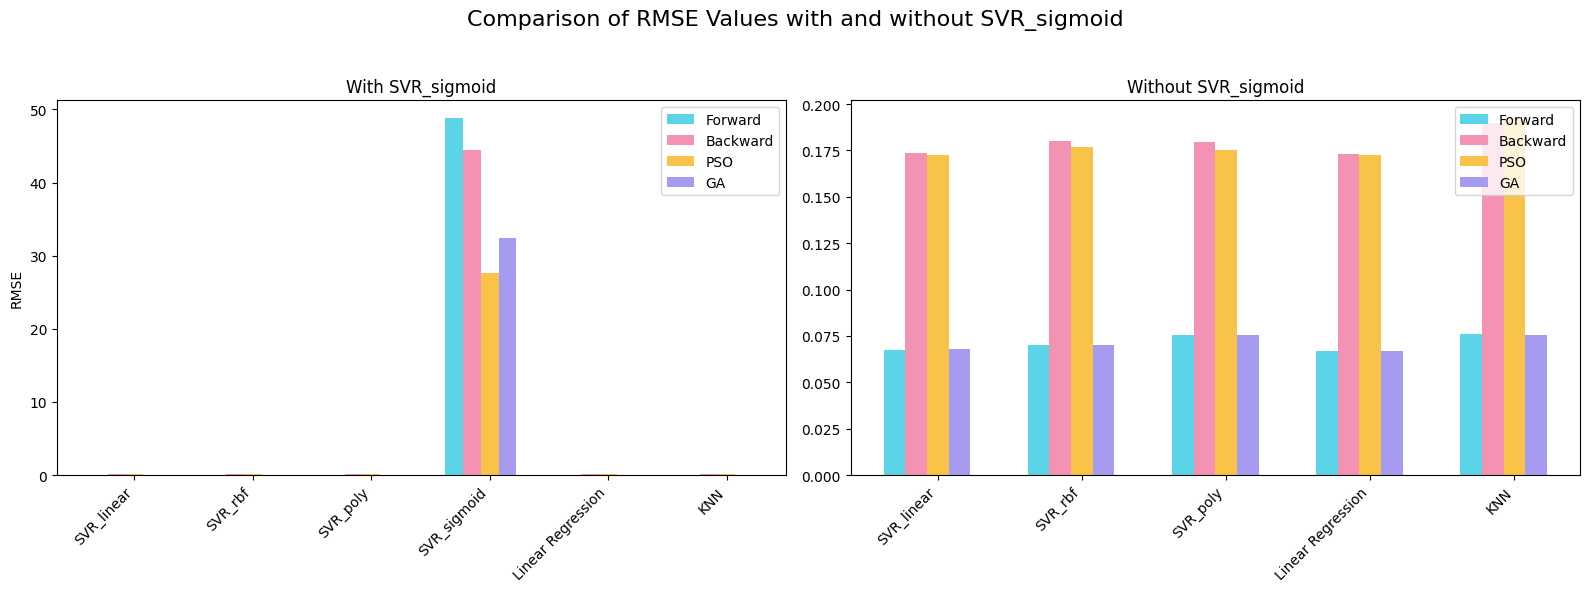

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# RMSE values
rmse_values_with_sigmoid = {
    'Forward': {'SVR_linear': 0.0673, 'SVR_rbf': 0.0702, 'SVR_poly': 0.0756, 'SVR_sigmoid': 48.7975, 'Linear Regression': 0.0670, 'KNN': 0.0759},
    'Backward': {'SVR_linear': 0.1739, 'SVR_rbf': 0.1800, 'SVR_poly': 0.1797, 'SVR_sigmoid': 44.4776, 'Linear Regression': 0.1732, 'KNN': 0.1897},
    'PSO': {'SVR_linear': 0.1726, 'SVR_rbf': 0.1768, 'SVR_poly': 0.1753, 'SVR_sigmoid': 27.6299, 'Linear Regression': 0.1723, 'KNN': 0.1924},
    'GA': {'SVR_linear': 0.0682, 'SVR_rbf': 0.0702, 'SVR_poly': 0.0755, 'SVR_sigmoid': 32.4450, 'Linear Regression': 0.0668, 'KNN': 0.0758}
}

rmse_values_without_sigmoid = {
    'Forward': {'SVR_linear': 0.0673, 'SVR_rbf': 0.0702, 'SVR_poly': 0.0756, 'Linear Regression': 0.0670, 'KNN': 0.0759},
    'Backward': {'SVR_linear': 0.1739, 'SVR_rbf': 0.1800, 'SVR_poly': 0.1797, 'Linear Regression': 0.1732, 'KNN': 0.1897},
    'PSO': {'SVR_linear': 0.1726, 'SVR_rbf': 0.1768, 'SVR_poly': 0.1753, 'Linear Regression': 0.1723, 'KNN': 0.1924},
    'GA': {'SVR_linear': 0.0682, 'SVR_rbf': 0.0702, 'SVR_poly': 0.0755, 'Linear Regression': 0.0668, 'KNN': 0.0758}
}

# Colors for bars
colors = ['#5AD4E6', '#F392B2', '#F9C349', '#A59BEF']

# Methods and models
methods = list(rmse_values_with_sigmoid.keys())
models_with_sigmoid = list(rmse_values_with_sigmoid['Forward'].keys())
models_without_sigmoid = list(rmse_values_without_sigmoid['Forward'].keys())
width = 0.15

# Prepare x-axis values
x_with_sigmoid = np.arange(len(models_with_sigmoid))
x_without_sigmoid = np.arange(len(models_without_sigmoid))

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot for RMSE values with SVR_sigmoid
for i, method in enumerate(methods):
    axs[0].bar(x_with_sigmoid + i * width, list(rmse_values_with_sigmoid[method].values()), width, label=method, color=colors[i])

axs[0].set_title('With SVR_sigmoid')
axs[0].set_xticks(x_with_sigmoid + width * len(methods) / 2)
axs[0].set_xticklabels(models_with_sigmoid, rotation=45, ha='right')
axs[0].set_ylabel('RMSE')
axs[0].legend()

# Plot for RMSE values without SVR_sigmoid
for i, method in enumerate(methods):
    axs[1].bar(x_without_sigmoid + i * width, list(rmse_values_without_sigmoid[method].values()), width, label=method, color=colors[i])

axs[1].set_title('Without SVR_sigmoid')
axs[1].set_xticks(x_without_sigmoid + width * len(methods) / 2)
axs[1].set_xticklabels(models_without_sigmoid, rotation=45, ha='right')
axs[1].legend()

# Adjust layout
fig.suptitle('Comparison of RMSE Values with and without SVR_sigmoid', fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


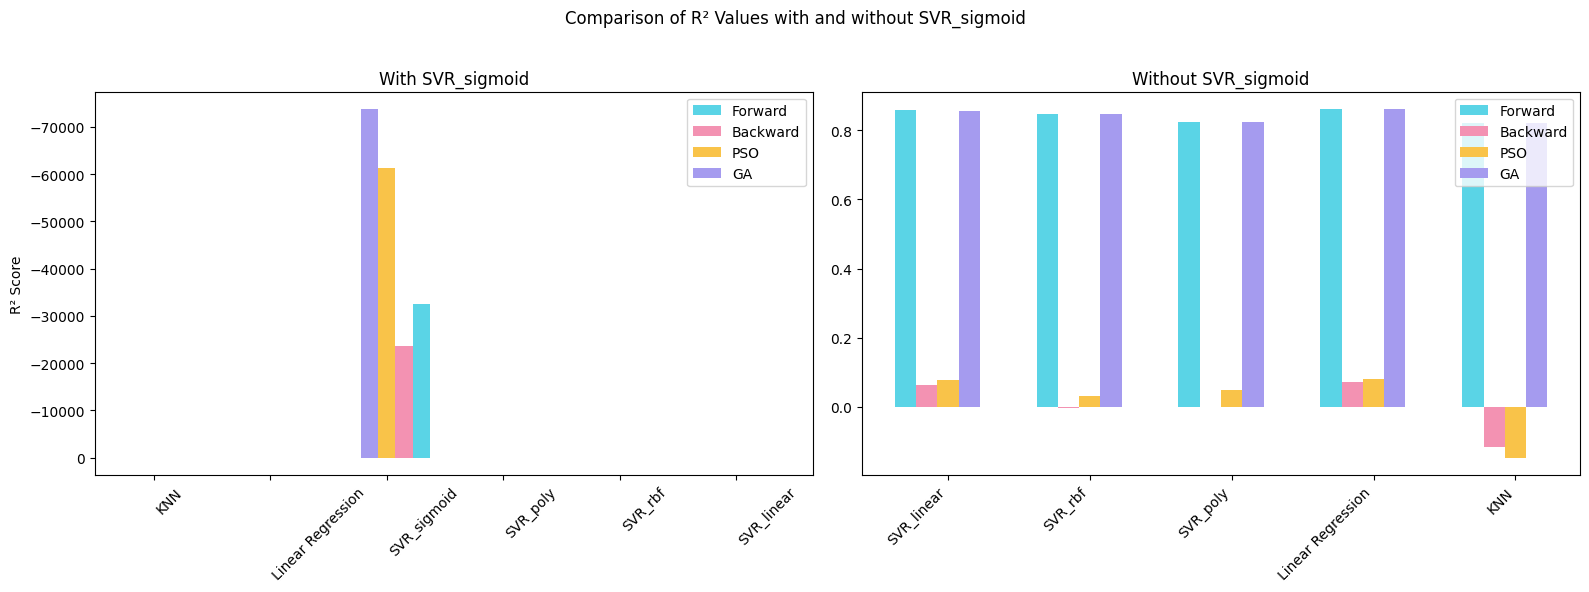

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample R² values for both scenarios
R_squared_values_with_sigmoid = {
    'Forward': {'SVR_linear': 0.8597, 'SVR_rbf': 0.8475, 'SVR_poly': 0.8228, 'SVR_sigmoid': -32606.3440, 'Linear Regression': 0.8608, 'KNN': 0.8216},
    'Backward': {'SVR_linear': 0.0634, 'SVR_rbf': -0.0035, 'SVR_poly': -0.0000, 'SVR_sigmoid': -23646.1214, 'Linear Regression': 0.0709, 'KNN': -0.1150},
    'PSO': {'SVR_linear': 0.0776, 'SVR_rbf': 0.0321, 'SVR_poly': 0.0485, 'SVR_sigmoid': -61276.5690, 'Linear Regression': 0.0803, 'KNN': -0.1470},
    'GA': {'SVR_linear': 0.8558, 'SVR_rbf': 0.8473, 'SVR_poly': 0.8236, 'SVR_sigmoid': -73757.8809, 'Linear Regression': 0.8616, 'KNN': 0.8222}
}

R_squared_values_without_sigmoid = {
    'Forward': {'SVR_linear': 0.8597, 'SVR_rbf': 0.8475, 'SVR_poly': 0.8228, 'Linear Regression': 0.8608, 'KNN': 0.8216},
    'Backward': {'SVR_linear': 0.0634, 'SVR_rbf': -0.0035, 'SVR_poly': -0.0000, 'Linear Regression': 0.0709, 'KNN': -0.1150},
    'PSO': {'SVR_linear': 0.0776, 'SVR_rbf': 0.0321, 'SVR_poly': 0.0485, 'Linear Regression': 0.0803, 'KNN': -0.1470},
    'GA': {'SVR_linear': 0.8558, 'SVR_rbf': 0.8473, 'SVR_poly': 0.8236, 'Linear Regression': 0.8616, 'KNN': 0.8222}
}

# Colors for each method
colors = ['#5AD4E6', '#F392B2', '#F9C349', '#A59BEF']

methods = list(R_squared_values_with_sigmoid.keys())
models_with_sigmoid = list(R_squared_values_with_sigmoid['Forward'].keys())
models_without_sigmoid = list(R_squared_values_without_sigmoid['Forward'].keys())
width = 0.15

x_with_sigmoid = np.arange(len(models_with_sigmoid))
x_without_sigmoid = np.arange(len(models_without_sigmoid))

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot for R² values with SVR_sigmoid
for i, method in enumerate(methods):
    axs[0].bar(x_with_sigmoid + i * width, list(R_squared_values_with_sigmoid[method].values()), width, label=method, color=colors[i])

axs[0].invert_yaxis()
axs[0].invert_xaxis()
axs[0].set_title('With SVR_sigmoid')
axs[0].set_xticks(x_with_sigmoid + width * len(methods) / 2)
axs[0].set_xticklabels(models_with_sigmoid, rotation=45, ha='left')
axs[0].set_ylabel('R² Score')
axs[0].legend()

# Plot for R² values without SVR_sigmoid
for i, method in enumerate(methods):
    axs[1].bar(x_without_sigmoid + i * width, list(R_squared_values_without_sigmoid[method].values()), width, label=method, color=colors[i])

axs[1].set_title('Without SVR_sigmoid')
axs[1].set_xticks(x_without_sigmoid + width * len(methods) / 2)
axs[1].set_xticklabels(models_without_sigmoid, rotation=45, ha='right')
axs[1].legend()

# Adjust layout
fig.suptitle('Comparison of R² Values with and without SVR_sigmoid')
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
